# Run this notebook third

This notebook will visualize some image outputs from the Fast Gradient Sign Method attack on a star-galaxy dataset. You may need to update some of the options (e.g., `data_full_path`, etc.) below for your local situation. If you need a copy of the data, see the instructions at the root-level README.

The notebook will produce a PDF of images with the FGSM attack applied.

In [1]:
import sys
import numpy as np
import torch
from torch.nn import Softmax
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
sys.path.append("..")

In [3]:
from ptlib.dataloaders import AttackedDataManager as DataManager
from ptlib.datasets import AttackedStarGalaxyDataset as AttackedDataset

In [4]:
batch_size = 4
data_full_path = "./fgsm_0_010.hdf5"
dtype = 'float64'
num_batches = 10
pdf_name = "evts_0_010.pdf"

In [5]:
sm = Softmax(dim=0)
data_manager = DataManager(data_full_path=data_full_path,
                           data_set_cls=AttackedDataset)
dl = data_manager.get_data_loader(batch_size=batch_size)

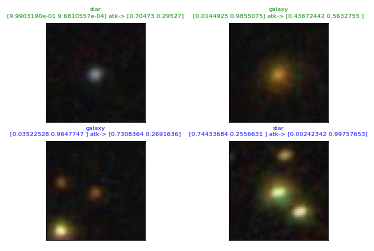

In [6]:
with PdfPages(pdf_name) as pdf:
    for iter_num, (inputs, labels, init_outputs, perturbed_outputs) \
            in enumerate(dl, 0):
        if iter_num >= num_batches:
            break
        n_cols = int(np.sqrt(batch_size))
        n_rows = int(np.ceil(batch_size / n_cols))
        # make grid, plots
        gs = plt.GridSpec(n_rows, n_cols)
        for evt, img_tnsr in enumerate(inputs):
            # color codes
            # * green if prediction is correct and adv fails
            # * red if prediction is wrong and adv doesn't flip
            # * blue if prediction is correct and adv flips
            # * black if prediction is wrong and adv doesn't flip
            adv_swp = torch.argmax(init_outputs[evt]) == \
                torch.argmax(perturbed_outputs[evt])
            init_pred_correct = torch.argmax(init_outputs[evt]) == \
                labels[evt]
            color = 'k'
            if init_pred_correct and adv_swp:
                color = 'g'
            if init_pred_correct and (not adv_swp):
                color = 'b'
            if (not init_pred_correct) and (not adv_swp):
                color = 'r'
            titlestr = data_manager.label_names[labels[evt]] + '\n' + \
                str(sm(init_outputs[evt]).numpy()) + ' atk-> ' + \
                str(sm(perturbed_outputs[evt]).numpy())
            ax = plt.subplot(gs[evt])
            ax.axis('on')
            ax.xaxis.set_major_locator(plt.NullLocator())
            ax.yaxis.set_major_locator(plt.NullLocator())
            _ = ax.imshow(
                np.moveaxis(img_tnsr.numpy().astype(dtype), 0, -1))
            plt.title(titlestr, fontsize=6, color=color)
        pdf.savefig()